In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from kernels import *
import pdb
import gpytorch
from itertools import product

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
train_x = torch.linspace(float(0), float(1), int(50))
one = torch.sin(train_x * (float(2) * math.pi)) + torch.randn(train_x.size()) * float(0.2)
two = torch.cos(train_x * (float(2) * math.pi)) + torch.randn(train_x.size()) * float(0.2)
train_y = torch.stack([one, two], int(-1))


In [3]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ZeroMean(), num_tasks=2
        )
        
        kernel = Diff_SE_kernel(input_dim=int(1))
        kernel2 = Diff_SE_kernel(input_dim=int(1))
        self.covar_module = MatrixKernel(int(1), [kernel, kernel2])

    def forward(self, x):
        #pdb.set_trace()
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        #print(f"{covar_x}")
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x, validate_args=True)


likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
model = MultitaskGPModel(train_x, train_y, likelihood)

In [4]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = int(2) if smoke_test else int(20)


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=float(0.1))  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    #print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f  variance: %.3f noise: %.3f' % (
    #    i + 1, training_iter, loss.item(),
    #    model.covar_module.length.item(),
    #    model.covar_module.var.item(),
    #    model.likelihood.noise.item()
    #))
    optimizer.step()

In [5]:
for p in model.named_parameters():
    print(p)

('likelihood.raw_task_noises', Parameter containing:
tensor([-2.0385, -2.0546], requires_grad=True))
('likelihood.raw_noise', Parameter containing:
tensor([-2.0472], requires_grad=True))
('covar_module.kernel_0.var', Parameter containing:
tensor(0.5080, requires_grad=True))
('covar_module.kernel_0.length', Parameter containing:
tensor(0.2011, requires_grad=True))
('covar_module.kernel_1.var', Parameter containing:
tensor(0.9445, requires_grad=True))
('covar_module.kernel_1.length', Parameter containing:
tensor(0.3076, requires_grad=True))


In [6]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots

number_of_samples = int(20)
# Make predictions
with torch.no_grad():#, gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(float(0), float(2), number_of_samples)
    #pdb.set_trace()
    outputs = model(test_x)
    predictions = likelihood(outputs)
    
    mean = predictions.mean
    lower, upper = predictions.confidence_region()
#print(mean)
#print(lower)
#print(upper)
# This contains predictions for both tasks, flattened out
# The first half of the predictions is for the first task
# The second half is for the second task

#dims = int(2)
#indices = [list(range(i, len(train_y), dims)) for i in range(dims)]


Text(0.5, 1.0, 'Observed Values (Likelihood)')

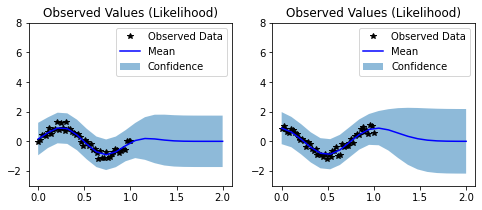

In [7]:
f, (y1_ax, y2_ax) = plt.subplots(int(1), int(2), figsize=(int(8), int(3)))

# Plot training data as black stars
y1_ax.plot(train_x.detach().numpy(), train_y[:, 0].detach().numpy(), 'k*')
# Predictive mean as blue line
y1_ax.plot(test_x.numpy(), mean[:, 0].numpy(), 'b')
# Shade in confidence
y1_ax.fill_between(test_x.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
y1_ax.set_ylim([-3, 8])
y1_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y1_ax.set_title('Observed Values (Likelihood)')

# Plot training data as black stars
y2_ax.plot(train_x.detach().numpy(), train_y[:, 1].detach().numpy(), 'k*')
# Predictive mean as blue line
y2_ax.plot(test_x.numpy(), mean[:, 1].numpy(), 'b')
# Shade in confidence
y2_ax.fill_between(test_x.numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.5)
y2_ax.set_ylim([-3, 8])
y2_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y2_ax.set_title('Observed Values (Likelihood)')


# Test Diffable SE Kernel

In [8]:
X = torch.tensor([int(1), int(2), int(3)])

In [12]:
x1, x2, l, sigma = var('x1, x2, l, sigma')
lengthscale = 1
variance = 1
SE(x1, x2, l, sigma) = sigma^2*exp(-(x1-x2)^2/(2*l^2))
cov_matr = [[None for i in range(len(X))] for j in range(len(X))]
for i, (v1, v2) in enumerate(product(X, X)):
    cov_matr[int(i/len(X))][int(i%len(X))] = SE.diff(x2).diff(x2)(int(v1), int(v2), lengthscale, variance)
cov_matr

[[-1, 0, 3*e^(-2)], [0, -1, 0], [3*e^(-2), 0, -1]]

In [10]:
a = Diff_SE_kernel(input_dim=int(1), var=int(variance), length=int(lengthscale))
dx1, dx2 = var('dx1, dx2')
left_poly = 1
right_poly = dx2^2
a.asymmetric_deriv(left_poly=left_poly, right_poly=right_poly)(X)

SUCCESS
> /Users/andreas/Documents/container_storage/sage/DiffEqGPs/kernels.py(307)prepare_asym_deriv_dict()
    305                     # Check if either left or right is number
    306                     # -> make coefficient
--> 307                     if type(d_poly) in [sage.rings.integer.Integer,
    308                                         sage.rings.real_mpfr.RealLiteral]:
    309                         degr = 0

ipdb> c
> /Users/andreas/Documents/container_storage/sage/DiffEqGPs/kernels.py(304)prepare_asym_deriv_dict()
    302                 for d_poly, d_var in zip(left_right, [left_d_var, right_d_var]):
    303                     import pdb
--> 304                     pdb.set_trace()
    305                     # Check if either left or right is number
    306                     # -> make coefficient

ipdb> c
(x1-x2)^i : [0, 2]
Coefficients: [1, 1]
Starting sign: -1
l^(2*N) : [1.0, 2.0]


tensor([[-1.0000,  0.0000,  0.4060],
        [ 0.0000, -1.0000,  0.0000],
        [ 0.4060,  0.0000, -1.0000]], grad_fn=<MulBackward0>)

In [11]:

left_poly.has(dx1) and len(left_poly.operands()) == 0

AttributeError: 'sage.rings.integer.Integer' object has no attribute 'has'